Processing ATLAS data from monojet_Zp2000.0_DM_50.0_chan3 and training an autoencoder to compress jet four-momentum into three components.

Adopted from ATLAS autoencoders project through Google Summer of Code 2021. Edited and completed by Zachary Martin.

## Look into the dataset

First we need to make sure that Python 3.8 is used in the notebook. It is required in order to open this certain .pkl-file. 

In [1]:
import sys
sys.version

'3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]'

The usual packages:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# a style I like to use for plots
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
# define arbitrary seed for randomization
SEED = 20210317

We read in the necessary datafile

In [4]:
# array to store four momenta
four_mom = []

# read file line by line
with open('monojet_Zp2000.0_DM_50.0_chan3.csv') as rawdata:
    lines = rawdata.readlines()
    for line in lines:
        # ignore event ID through METphi
        objects = line.split(';')[5:]
        # take only jets, 'j'
        for obj in objects:
            if 'j' in obj:
                # remove obj label and store four momentum
                four_mom.append(obj.split(',')[1:])

# convert four_mom to pandas dataframe (because we like dataframes)
col_names = ['E', 'pt', 'eta', 'phi']
data = pd.DataFrame(four_mom, columns=col_names, dtype=float)

display(data)

,E,pt,eta,phi
0,258722.0,243675.0,0.328962,2.250140
1,520092.0,108590.0,-2.247300,-1.856790
2,383024.0,88405.6,2.145160,-1.956350
3,39507.6,35365.1,0.470460,-1.164450
4,225430.0,26878.2,-2.816080,-2.259380
...,...,...,...,...
22656,731849.0,722541.0,-0.134499,2.563930
22657,268828.0,259144.0,0.153813,0.578428
22658,153340.0,43931.5,1.920140,-0.237382
22659,893689.0,742040.0,-0.618057,-3.104660


We can quickly view it as plots:

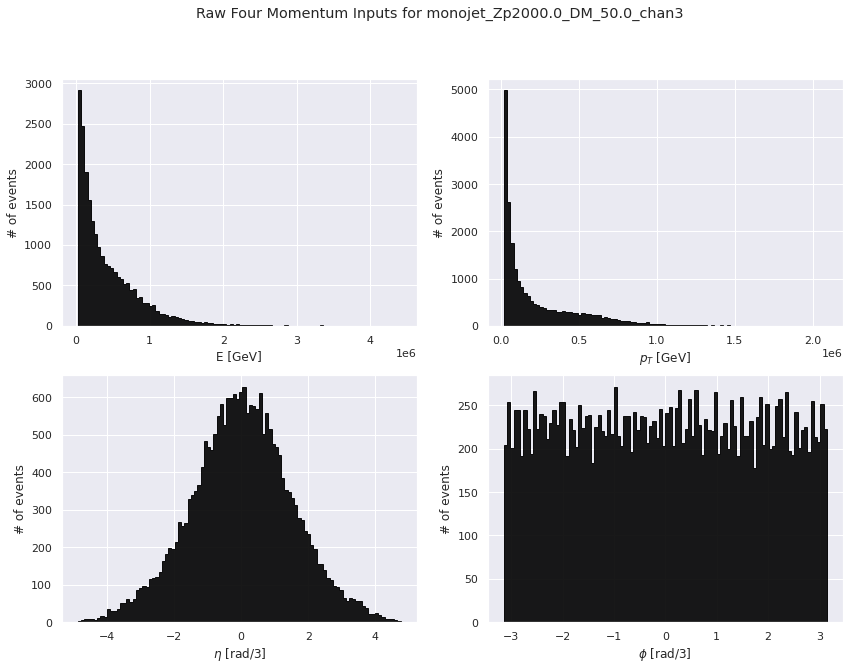

In [5]:
# plotting
fig, axs = plt.subplots(2,2, figsize=[14,10])
axs = np.array(axs).flatten() # so we can use a single index to call

plt.suptitle('Raw Four Momentum Inputs for monojet_Zp2000.0_DM_50.0_chan3')

unit_list = ['[GeV]', '[GeV]', '[rad/3]', '[rad/3]']
variable_list = [r'E', r'$p_T$', r'$\eta$', r'$\phi$']
branches=["E","pt","eta","phi"]
n_bins = 100

# plot on each subplot
for kk, ax in zip(range(0,4), axs):
    ax.hist(data[branches[kk]], color='black', label='Input', alpha=0.9, bins=n_bins, histtype='stepfilled',ec='black',lw=1)
    ax.set_xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax.set_ylabel('# of events')
    
# plt.savefig("fourmomentum_raw.png",dpi=300)
plt.show()

Notice two things: E and pt >> eta and phi and so may have stronger effects during training, and the distributions are far from normal. To prevent such effects, we should standardize the inputs. From the graphs of the data, taking the log of E and pt are enough to give enough of a normal distribution. But for better results, I've taken both the log and used the StandardScaler class in sklearn to truly standardize each input. This will make learning from the data much easier. And the scaler has an inverse_transform to give us back the true values as well.

In [6]:
from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.preprocessing import scale

# log E and pt
log_data = data.copy()

log_data['E'] = np.log10(log_data['E'])
log_data['pt'] = np.log10(log_data['E'])

display(log_data)

# standardize the inputs
scaler = Scaler()
scaler.fit(log_data)
scaled_data = scaler.transform(log_data)

# print(scaled_data)

# returns ndarray, so go back to dataframe
scaled_data = pd.DataFrame(scaled_data, columns=col_names, dtype=float)
display(scaled_data)

,E,pt,eta,phi
0,5.412833,0.733425,0.328962,2.250140
1,5.716080,0.757098,-2.247300,-1.856790
2,5.583226,0.746885,2.145160,-1.956350
3,4.596681,0.662444,0.470460,-1.164450
4,5.353012,0.728598,-2.816080,-2.259380
...,...,...,...,...
22656,5.864421,0.768225,-0.134499,2.563930
22657,5.429475,0.734758,0.153813,0.578428
22658,5.185655,0.714804,1.920140,-0.237382
22659,5.951186,0.774604,-0.618057,-3.104660


,E,pt,eta,phi
0,-0.029548,0.013338,0.210465,1.249834
1,0.631174,0.648194,-1.500110,-1.018858
2,0.341708,0.374309,1.416375,-1.073856
3,-1.807801,-1.890138,0.304416,-0.636406
4,-0.159889,-0.116093,-1.877766,-1.241251
...,...,...,...,...
22656,0.954383,0.946582,-0.097262,1.423174
22657,0.006710,0.049089,0.094170,0.326370
22658,-0.524529,-0.486020,1.266968,-0.124288
22659,1.143429,1.117631,-0.418333,-1.708189


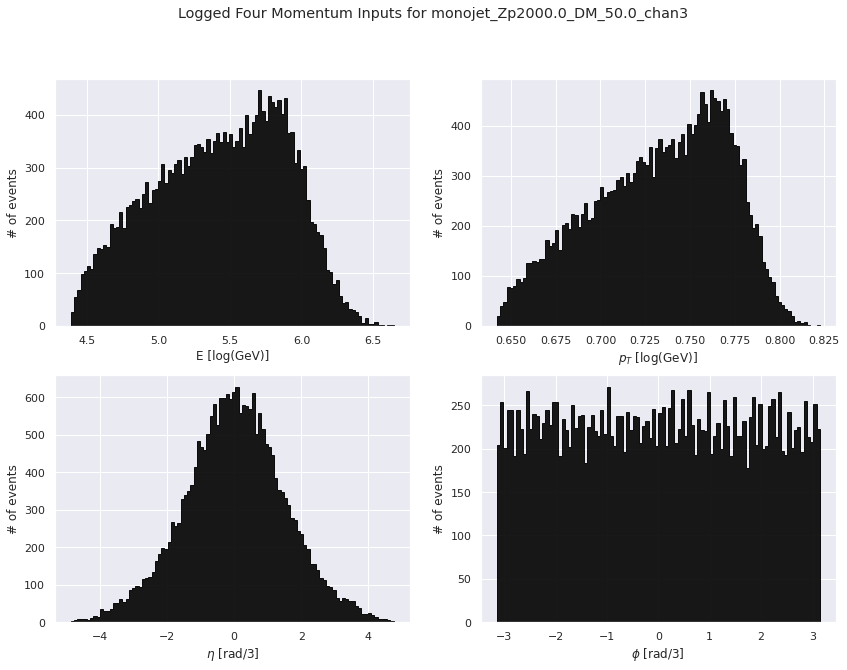

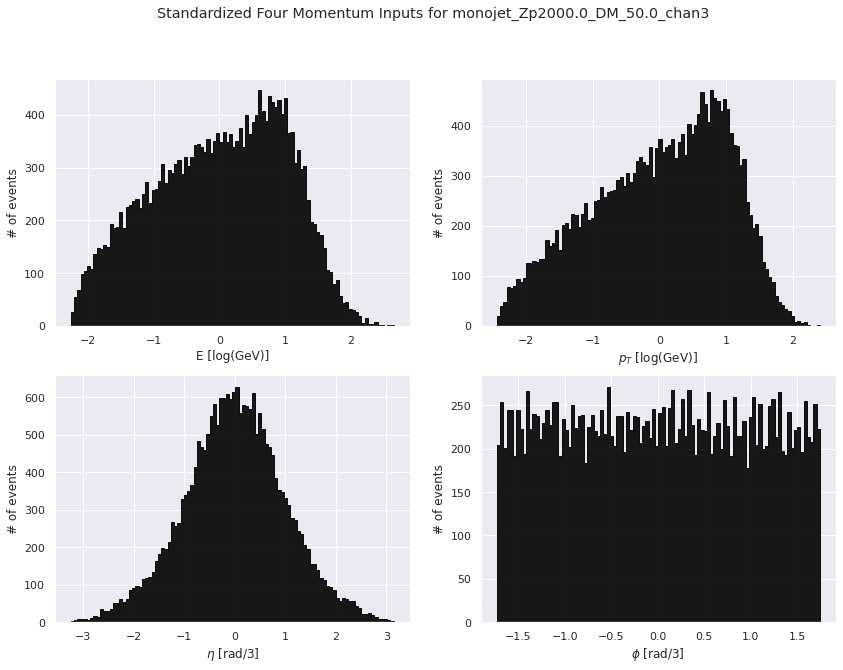

In [7]:
# plotting logged data
fig, axs = plt.subplots(2,2, figsize=[14,10])
axs = np.array(axs).flatten() # so we can use a single index to call

plt.suptitle('Logged Four Momentum Inputs for monojet_Zp2000.0_DM_50.0_chan3')

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'E', r'$p_T$', r'$\eta$', r'$\phi$']
branches=["E","pt","eta","phi"]
n_bins = 100

# plot on each subplot
for kk, ax in zip(range(0,4), axs):
    ax.hist(log_data[branches[kk]], color='black', label='Input', alpha=0.9, bins=n_bins, histtype='stepfilled',ec='black',lw=1)
    ax.set_xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax.set_ylabel('# of events')
    
# plt.savefig("fourmomentum_log.png",dpi=300)
plt.show()

# plotting standardized data
fig, axs = plt.subplots(2,2, figsize=[14,10])
axs = np.array(axs).flatten() # so we can use a single index to call

plt.suptitle('Standardized Four Momentum Inputs for monojet_Zp2000.0_DM_50.0_chan3')

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'E', r'$p_T$', r'$\eta$', r'$\phi$']
branches=["E","pt","eta","phi"]
n_bins = 100

# plot on each subplot
for kk, ax in zip(range(0,4), axs):
    ax.hist(scaled_data[branches[kk]], color='black', label='Input', alpha=0.9, bins=n_bins, histtype='stepfilled',ec='black',lw=1)
    ax.set_xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax.set_ylabel('# of events')
    
# plt.savefig("fourmomentum_standardized.png",dpi=300)
plt.show()

Again, we can reverse the standardized scaling. Below is how:

In [8]:
# to reverse the scaling
reverse_scale = scaler.inverse_transform(scaled_data)

reverse_scale = pd.DataFrame(reverse_scale, columns=col_names, dtype=float)

display(reverse_scale - log_data)

,E,pt,eta,phi
0,0.0,0.0,0.000000e+00,0.0
1,0.0,0.0,0.000000e+00,0.0
2,0.0,0.0,0.000000e+00,0.0
3,0.0,0.0,0.000000e+00,0.0
4,0.0,0.0,0.000000e+00,0.0
...,...,...,...,...
22656,0.0,0.0,0.000000e+00,0.0
22657,0.0,0.0,0.000000e+00,0.0
22658,0.0,0.0,0.000000e+00,0.0
22659,0.0,0.0,0.000000e+00,0.0


Data is currently sorted by event properties (event weight, MET, METphi). We will lessen any sorting biases or imbalance by first shuffling the data.

In [9]:
# shuffle the data
shuffled_data = scaled_data.copy()
shuffled_data = shuffled_data.sample(frac=1, random_state=SEED)

display(shuffled_data)

,E,pt,eta,phi
17098,1.230961,1.195987,-0.717741,-0.008906
13099,-0.231615,-0.187936,-1.866226,1.300053
20619,-0.053509,-0.010347,0.220572,-0.865334
5455,1.006791,0.994253,-0.428698,1.324332
22372,0.471750,0.498149,0.474601,1.144954
...,...,...,...,...
20043,0.975730,0.966024,-0.241178,0.714984
5145,-0.760152,-0.731465,0.201899,-1.270137
13112,1.019017,1.005346,-0.329572,0.168291
5932,-1.508734,-1.547456,0.624363,-0.989713


Given a single data set, we will randomly split using a common train-test split of train:80%, test:20%

In [10]:
# sample 80% to get training data
train = shuffled_data.sample(frac=.8, random_state=SEED)

# the rest (20%) is testing data, so drop the training data
train_indices = train.index[True][0]
test = shuffled_data.drop(train_indices)

print('Training data')
display(train)
print('The number of entries in the training data:', len(train), '(80%)')

print('\n----------------------\n')

print('Testing data')
display(test)
print('The number of entries in the validation data:', len(test), '(20%)')

Training data


,E,pt,eta,phi
4622,1.676218,1.586606,1.227255,-0.768906
261,-0.018527,0.024217,0.224607,-1.678497
18560,-0.445271,-0.404607,-0.737195,1.066485
281,0.599420,0.618462,0.472093,-1.183453
11739,0.271654,0.307047,1.543188,0.037344
...,...,...,...,...
13462,-0.472280,-0.432287,-1.204940,1.075865
19351,-0.777221,-0.749448,0.695597,-0.334174
492,-0.059968,-0.016741,-1.964355,0.088513
15934,-0.763577,-0.735072,-1.547797,1.482695


The number of entries in the training data: 18129 (80%)

----------------------

Testing data


,E,pt,eta,phi
13099,-0.231615,-0.187936,-1.866226,1.300053
13036,-0.631895,-0.597221,0.315802,-0.962220
1765,-1.202343,-1.206536,-0.617974,-0.912382
16509,0.989478,0.978527,0.364221,0.171129
7443,0.535706,0.558575,0.666309,0.875021
...,...,...,...,...
18116,0.732100,0.742193,2.000548,-0.600466
2165,0.633734,0.650587,0.434188,-1.153419
16364,-0.735486,-0.705527,0.713186,1.645622
1448,0.521572,0.545248,0.852873,0.527708


The number of entries in the validation data: 4532 (20%)


## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [12]:
bs = 256 # batch size

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [13]:
# create our autoencoder
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [14]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.003981071710586548
Learning rate with the steepest gradient: 0.005248074419796467


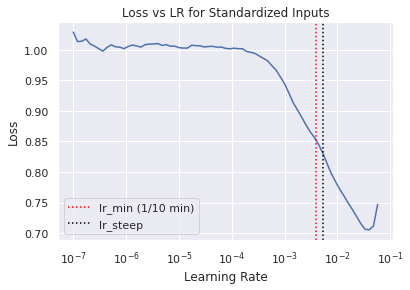

In [16]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

plt.title('Loss vs LR for Standardized Inputs')
plt.axvline(lr_min, linestyle='dotted', c='red', label='lr_min (1/10 min)')
plt.axvline(lr_steep, linestyle='dotted', c='black', label='lr_steep')
plt.legend()
# plt.savefig('LvLR_standard1.png', dpi=300)

# lr_min = 0.005754399299621582
# lr_steep = 0.0014454397605732083

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [17]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

# Training takes <70s

[0, 0.497784823179245, 0.3122139573097229, '00:00']
[0, 0.497784823179245, 0.3122139573097229, '00:00']
[1, 0.2236294448375702, 0.07568518072366714, '00:00']
[1, 0.2236294448375702, 0.07568518072366714, '00:00']
[2, 0.08254165947437286, 0.026329312473535538, '00:00']
[2, 0.08254165947437286, 0.026329312473535538, '00:00']
[3, 0.027615001425147057, 0.00476140808314085, '00:00']
[3, 0.027615001425147057, 0.00476140808314085, '00:00']
[4, 0.008076069876551628, 0.0012231175787746906, '00:00']
[4, 0.008076069876551628, 0.0012231175787746906, '00:00']
[5, 0.0026983385905623436, 0.0008753588772378862, '00:00']
[5, 0.0026983385905623436, 0.0008753588772378862, '00:00']
[6, 0.001291900873184204, 0.000820811721496284, '00:00']
[6, 0.001291900873184204, 0.000820811721496284, '00:00']
[7, 0.001047696452587843, 0.0011325898813083768, '00:00']
[7, 0.001047696452587843, 0.0011325898813083768, '00:00']
[8, 0.0008481988334096968, 0.0005074317450635135, '00:00']
[8, 0.0008481988334096968, 0.000507431745

[69, 8.366398833459243e-05, 5.690978287020698e-05, '00:00']
[69, 8.366398833459243e-05, 5.690978287020698e-05, '00:00']
[70, 7.715378887951374e-05, 8.805464312899858e-05, '00:00']
[70, 7.715378887951374e-05, 8.805464312899858e-05, '00:00']
[71, 6.327527080429718e-05, 8.313904982060194e-05, '00:00']
[71, 6.327527080429718e-05, 8.313904982060194e-05, '00:00']
[72, 5.1532857469283044e-05, 2.9421573344734497e-05, '00:00']
[72, 5.1532857469283044e-05, 2.9421573344734497e-05, '00:00']
[73, 3.909747829311527e-05, 4.8055102524813265e-05, '00:00']
[73, 3.909747829311527e-05, 4.8055102524813265e-05, '00:00']
[74, 4.5762713853036985e-05, 3.1105406378628686e-05, '00:00']
[74, 4.5762713853036985e-05, 3.1105406378628686e-05, '00:00']
[75, 3.6764158721780404e-05, 4.917694968753494e-05, '00:00']
[75, 3.6764158721780404e-05, 4.917694968753494e-05, '00:00']
[76, 3.216944605810568e-05, 3.668815043056384e-05, '00:00']
[76, 3.216944605810568e-05, 3.668815043056384e-05, '00:00']
[77, 3.2684256439097226e-05,

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

Text(0, 0.5, 'Loss')

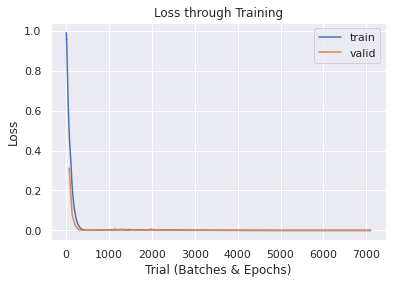

In [18]:
recorder.plot_loss()
plt.title('Loss through Training')
plt.xlabel('Trial (Batches & Epochs)')
plt.ylabel('Loss')

# plt.savefig('loss.png', dpi=300)

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [19]:
learn.validate()
# <1e-5

(#1) [5.120947207615245e-06]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Make the histograms from the dataset...

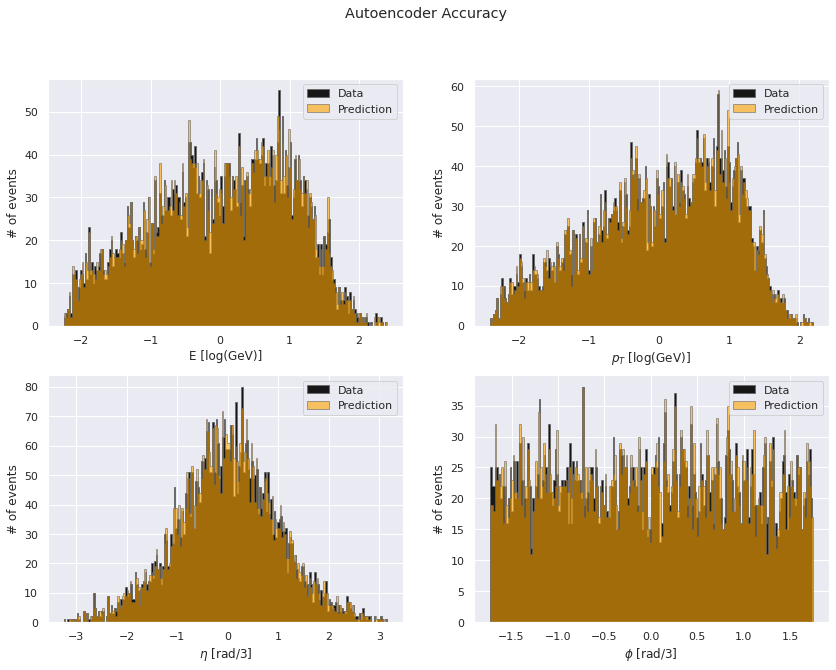

In [20]:
# plot decor
unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'E', r'$p_T$', r'$\eta$', r'$\phi$']
line_style = ['--', '-']
colors = ['orange', 'black']
markers = ['*', 's']

model.to('cpu')

# Data and Prediction Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

# plotting
fig, axs = plt.subplots(2,2, figsize=[14,10])
axs = np.array(axs).flatten()

plt.suptitle('Autoencoder Accuracy')

# to analyze later
hist_data = []
hist_pred = []

alph=0.6
n_bins=200

# plot on each subplot
for kk, ax in zip(range(0,4), axs):
    n_hist_data, bin_edges, _ = ax.hist(data[:, kk], color=colors[1], label='Data', alpha=0.9, bins=n_bins, histtype='stepfilled',ec='dimgray',lw=1)
    n_hist_pred, _, _ = ax.hist(pred[:, kk], color=colors[0], label='Prediction', alpha=alph, bins=n_bins, histtype='stepfilled',ec='dimgray',lw=1)
    hist_data.append(n_hist_data)
    hist_pred.append(n_hist_pred)
    ax.set_xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax.set_ylabel('# of events')
    ax.legend()

# plt.savefig("accuracy.png", dpi=300)
plt.show()

Now we analyze the accuracy of the autoencoder by looking at the difference ratios between the data and the predictions.

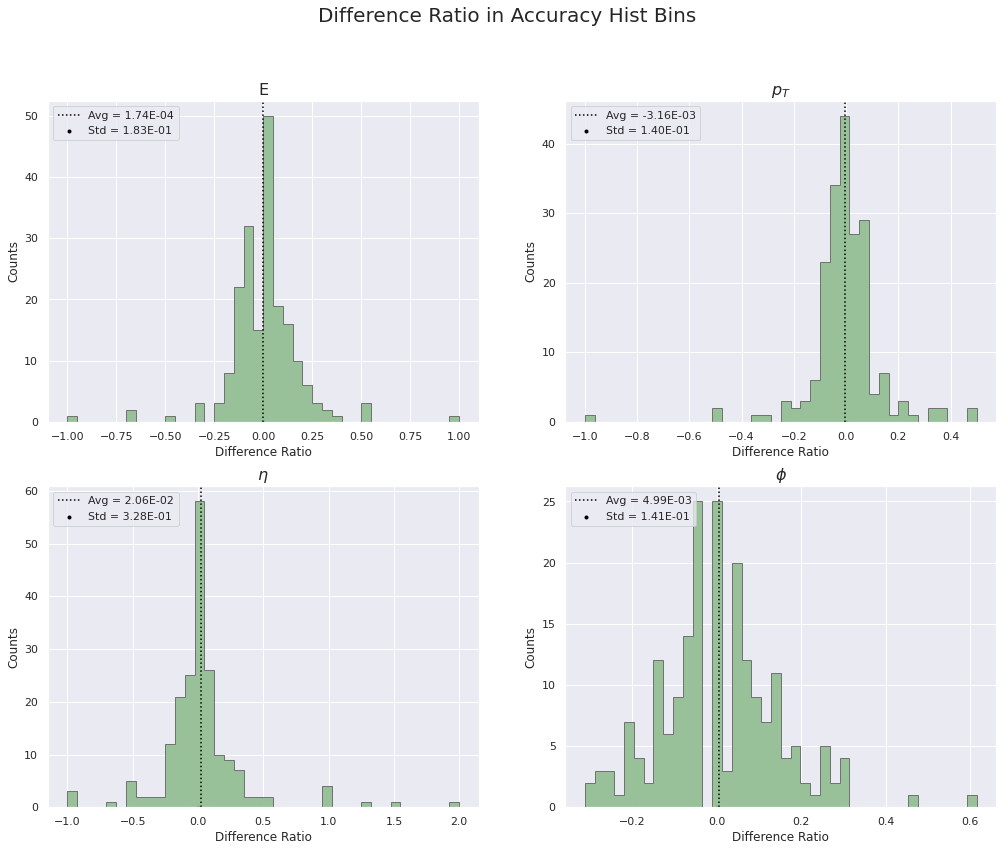

In [22]:
# function to get the difference ratio
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b1==0:
            continue
        else:
            bins.append((float(b2)-float(b1))/b1)
    return np.array(bins,dtype=float)   

# now to plot the ratios for each variable
fig, axs = plt.subplots(2,2, figsize=[17,13])
axs = np.array(axs).flatten() # so we can use a single index to call

plt.suptitle('Difference Ratio in Accuracy Hist Bins', fontsize=20)

variable_list = [r'E', r'$p_T$', r'$\eta$', r'$\phi$']
n_bins = 40

# plot on each subplot
for (hdata, hpred), ax, kk in zip(zip(hist_data, hist_pred), axs, range(4)):
    rat = getRatio(hdata,hpred)
    avg = np.mean(rat)
    std = np.std(rat)
    
    ax.hist(rat, color='darkseagreen', alpha=0.9, bins=n_bins, histtype='stepfilled',ec='dimgray',lw=1)
    ax.axvline(avg, linestyle='dotted', c='black', label='Avg = {:.2E}'.format(avg))
    ax.scatter(0,0,c='black',marker='.',label='Std = {:.2E}'.format(std))
    
    ax.set_xlabel('Difference Ratio')
    ax.set_ylabel('Counts')
    ax.set_title(variable_list[kk], fontsize=16)
    ax.legend(loc='upper left')
    
# plt.savefig("rat.png",dpi=300)
plt.show()